In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, Model, load_model  
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback 

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error

import random  
import math 
import os 
import re #Модуль Re для регулярных выражений в Python
import matplotlib.pyplot as plt 
%matplotlib inline

from IPython.display import clear_output
from google.colab import drive

import gc

import time

In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Базы/amazon_co-ecommerce_sample.csv',sep = ',')

In [ ]:
data = df.values
data.shape

(10000, 17)

In [ ]:
data[1][-2]

'Four Stars // 4.0 // 18 Dec. 2015 // By\n    \n    kenneth bell\n  \n on 18 Dec. 2015 // Very happy with the communication with funkybuys | Five Stars // 5.0 // 14 Jan. 2016 // By\n    \n    moosixty\n  \n on 14 Jan. 2016 // Great buy.'

In [ ]:
df[0:5]

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,NaN,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,NaN,NaN,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,NaN,Birthday present // 5.0 // 14 April 2014 // By...,NaN


# Feature Engineering

In [ ]:
all_manufact = df["manufacturer"]
all_manufact = all_manufact.tolist()

# сортируем производителей по частоте встречаемости в базе для дальнейшего объединения редковстречающихся в один класс
# это нужно чтобы уйти от длины вектора в 2.5к и обобщить редкие фирмы 
wCount = dict.fromkeys(all_manufact, 0)
for word in all_manufact:
  wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1
  wordsList = list(wCount.items())

wordsList.sort(key = lambda i:i[1], reverse=1)

print(wordsList)

sortedWords = []
  #Проходим по всем словам в отсортированном списке
for word in wordsList:
  sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов
print(sortedWords)

[('LEGO', 171), ('Disney', 167), ('Oxford Diecast', 156), ('Playmobil', 147), ('Star Wars', 120), ('Mattel', 114), ('Hasbro', 110), ('The Puppet Company', 109), ('MyTinyWorld', 93), ('Corgi', 90), ('Hornby', 87), ('Scalextric', 76), ('Pokémon', 69), ('Schleich', 68), ('Amscan', 65), ('Every-occasion-party-supplies', 62), ('Melissa & Doug', 59), ('FunKo', 59), ('Papo', 58), ('Tamiya', 57), ('Ravensburger', 56), ('Bristol Novelties', 53), ('Intex', 52), ('Hot Wheels', 50), ('Tobar', 49), ('Takara Tomy', 48), ('Revell-Monogram', 48), ('Thomas & Friends', 47), ('Marvel', 47), ('Q-Workshop', 47), ('Partyrama', 45), ('Generic', 43), ('Bruder', 43), ('Bandai', 42), ('Unknown', 42), ('Maisto', 41), ('Siku', 41), ('Baker Ross', 38), ('NECA', 38), ('DC Comics', 36), ('Ultra Pro', 33), ('Crayola', 33), ('Kato', 32), ('Transformers', 32), ('Ty', 31), ('AUTOart', 31), ('Character Options', 30), ('k2-accessories Jewellery Findings', 30), ('Hama', 30), ('Magic The Gathering', 28), ('Qualatex', 28), (

In [ ]:
# находим уникальные колличества отзывов
unic_number_of_reviews = df.number_of_reviews.unique()
print(len(unic_number_of_reviews))
# так как их слишком много то разобъем их на интервалы

195


In [ ]:
# находим уникальные колличества отзывов для разбиения на группы
unic_average_review_rating = df.average_review_rating.unique()
print(len(unic_average_review_rating))
list_unic_rating = unic_average_review_rating.tolist()

20


In [ ]:
unic_average_review_rating

array(['4.9 out of 5 stars', '4.5 out of 5 stars', '3.9 out of 5 stars',
       '5.0 out of 5 stars', '4.7 out of 5 stars', '4.3 out of 5 stars',
       '4.8 out of 5 stars', '4.0 out of 5 stars', '4.2 out of 5 stars',
       '4.6 out of 5 stars', '4.1 out of 5 stars', nan,
       '4.4 out of 5 stars', '3.5 out of 5 stars', '3.0 out of 5 stars',
       '3.3 out of 5 stars', '3.7 out of 5 stars', '3.8 out of 5 stars',
       '3.6 out of 5 stars', '2.3 out of 5 stars'], dtype=object)

In [ ]:
#d строка главного массива
def get_manufact(d,len_ohe):
  word = d[2]         # производитель
  if word in sortedWords[0:len_ohe]:
    ohe_manufact = utils.to_categorical(sortedWords.index(word), len(sortedWords[0:len_ohe+1]))
    return ohe_manufact
  else:
    ohe_manufact = utils.to_categorical(len_ohe, len(sortedWords[0:len_ohe+1])) # тем кто выпадают присваивается 150 адрес
    return ohe_manufact

def get_number_of_reviews(d):
  type_number = 0
  word = d[5]         # количество отзывов
  if word == word:
    try:
      word_int = int(word)
      if word_int < 2:
        type_number = 2
      elif word_int < 3:
        type_number = 3
      elif word_int < 4:
        type_number = 4
      elif word_int < 7:
        type_number = 5
      elif word_int < 11:
        type_number = 6
      elif word_int < 21:
        type_number = 7
      elif word_int < 41:
        type_number = 8
      else:
        type_number = 9
    except:
      type_number = 1

  type_number = utils.to_categorical(type_number, 10)
  return type_number

def get_average_review_rating(d):
  type_rating = 0
  word = d[7]         # рейтинг
  if word == word:# если не пропуск
    type_rating = list_unic_rating.index(word) + 1
  type_rating = utils.to_categorical(type_rating, len(unic_average_review_rating) + 1) # +1 резерв для NAN

  return type_rating

#Полуаем цену
def getCost(d):
  costStr = d[3] #Загружаем строку
#ОТБРОСИТЬ ЗНАЧОК ВАЛЮТЫ

  #costStr_clean = re.findall(r'\d+', costStr) # возвращает лист из одного элемента
  if costStr == costStr:
    try:
      cost = float(cost) #Пробуем превратить в число 
    except:
      cost = costStr.replace(costStr[0],'')
      try:
        cost = float(cost)
      except:
        cost = 0 
  else:
    cost = 0

  return cost



In [ ]:
costStr = data[100][3] #Загружаем строку
print(costStr)
costStr = costStr.replace(costStr[0],'')
print(costStr)
cost = float(costStr)
print(cost)
type(cost)

£36.35
36.35
36.35


float

In [ ]:
#Объединяем все числовые параметры вместе
def getAllParameters(d, len_ohe):
  manufact = get_manufact(d, len_ohe)
  number_of_reviews = get_number_of_reviews(d)
  rating = get_average_review_rating(d)

  out = list(manufact)
  out.extend(number_of_reviews)
  out.extend(rating)

  return out


In [ ]:

def getXTrain(data,len_ohe): 
  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, len_ohe) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain


In [ ]:
xTrain = getXTrain(data,150)
yTrain = getYTrain(data)
print(xTrain.shape)
print(yTrain.shape)

(10000, 182)
(10000,)


In [ ]:
xTrainScaled = xTrain

In [ ]:
print(yTrain[0:10])

[  3.42  16.99   9.99  39.99  32.19   6.99  24.99  69.93 235.58   0.  ]


In [ ]:
type(yTrain[0])

numpy.float64

In [ ]:
max(yTrain)

995.11

# Preprocessing

## Scaling numerical data

In [ ]:
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах 
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены 

In [ ]:
yTrainScaled.shape[0]

10000

In [ ]:
yTrainScaled[0]

array([-0.37885814])

In [ ]:

# Маска проверочной выборки
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

## Text to BOW

In [ ]:
data[0]

array(['eac7efa5dbd3d667f26eb3d3ab504464', 'Hornby 2014 Catalogue',
       'Hornby', '£3.42', '5\xa0new', '15', 1.0, '4.9 out of 5 stars',
       'Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains',
       'http://www.amazon.co.uk/Hornby-R8150-Catalogue-2015/dp/B00S9SUUBE | http://www.amazon.co.uk/Hornby-Book-Model-Railways-Edition/dp/1844860957 | http://www.amazon.co.uk/Hornby-Book-Scenic-Railway-Modelling/dp/1844861120 | http://www.amazon.co.uk/Peco-60-Plans-Book/dp/B002QVL16I | http://www.amazon.co.uk/Hornby-Gloucester | http://www.amazon.co.uk/Airfix-5014429781902',
       'Product Description Hornby 2014 Catalogue Box Contains 1 x one catalogue',
       'Technical Details Item Weight640 g Product Dimensions29.6 x 20.8 x 1 cm Manufacturer recommended age:6 years and up Item model numberR8148 Main Language(s)English manual, English Number of Game Players1 Number of Puzzle Pieces1 Assembly RequiredNo Scale1:72 Engine Typeelectric Track Width/GaugeHO Batteries Required?No

In [ ]:
data1 = data

In [ ]:
data2 = data1[:,-2].reshape(10000) 

In [ ]:
data2[0]

"Worth Buying For The Pictures Alone (As Ever) // 4.0 // 6 April 2014 // By\n    \n    Copnovelist\n  \n on 6 April 2014 // Part of the magic for me growing up as a boy was to buy (or be given) the new Hornby catalogue every year, even if it included 90% of the same products as the previous year.  I've still got my old ones dating back to the 70s and 80s somewhere.  These days the catalogue is especially informative in that it tells you the vintage of the rolling stock which is useful if you are dedicating your railway to one particular era and train company. | Amazing detail fabulous photography. // 5.0 // 11 April 2015 // By\n    \n    richard\n  \n on 11 April 2015 // Amazing detail, every credit to the photographer in this book, a worthy reference manual, as well as a sales brochure. even if you only have a passing interest in the hobby you will be transported to another time when we were all younger and in awe of the big trains. | 'Great Purchase' // 5.0 // 23 April 2014 // By\n  

In [ ]:

#print(data2[0], end='\n') 
data3 = []
for i in data2:
  try:
    new = re.sub('\d','',i)
    data3.append(new)
  except:     #688 и ещё какие-то не фильтруются и получается ошибка СЕРЬЁЗНЫЙ И НЕПОНЯТНЫЙ БАГ
#    new1 = re.sub('\d','',i)
    data3.append(new)
len(data3)

10000

In [ ]:

max_count_words = 5000
tokenizer = Tokenizer(max_count_words,filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff\[0-9]',oov_token= 'unknown', lower=True)

tokenizer.fit_on_texts(data3)
items = list(tokenizer.word_index.items())

In [ ]:
print(items[:10])
print(len(items))

[('unknown', 7031), ('the', 2), ('and', 3), ('on', 4), ('a', 5), ('by', 6), ('to', 7), ('it', 8), ('for', 9), ('i', 10)]
39844


In [ ]:
secuence_tr = tokenizer.texts_to_sequences(data3) # Обучающие тесты в индексы
#secuence_te = tokenizer.texts_to_sequences(x_test)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", data3[1])
print("Он же в виде последовательности индексов: ", secuence_tr[1], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Four Stars // . //  Dec.  // By
    
    kenneth bell
  
 on  Dec.  // Very happy with the communication with funkybuys | Five Stars // . //  Jan.  // By
    
    moosixty
  
 on  Jan.  // Great buy.
Он же в виде последовательности индексов:  [161, 28, 26, 6, 7031, 2209, 4, 26, 22, 104, 15, 2, 3211, 15, 7031, 34, 28, 23, 6, 7031, 4, 23, 18, 95] 



In [ ]:
print(secuence_tr[1])

[161, 28, 26, 6, 7031, 2209, 4, 26, 22, 104, 15, 2, 3211, 15, 7031, 34, 28, 23, 6, 7031, 4, 23, 18, 95]


In [ ]:
len(secuence_tr)

10000

In [ ]:
xTrain01 = tokenizer.sequences_to_matrix(secuence_tr) #П одаем xTrain в виде списка


In [ ]:
print(xTrain.shape)
print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(yTrain.shape)


(10000, 182)
(10000, 5000)
(10000,)


In [ ]:
xTrain01[0]

array([0., 0., 1., ..., 0., 0., 0.])

# Modelling


## Callback

In [ ]:
plot_tr_mae = []
plot_tr_mae1 = []
loss_gist = []
t_sum = []

def on_epoch_end(epoch, logs):
  t1 = time.time()
  
  pred = model.predict([xTrainScaled[valMask], xTrain01[valMask]])              #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten()                      #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()   #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled                                         #Считаем разность предсказания и правильных цен
  absDelta = abs(delta)                                                         #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки на проверочной", round(sum(absDelta) / (1e+6 * len(absDelta)),10)) #Выводим усреднённую ошибку в миллионах рублей

  pred1 = model.predict([xTrainScaled[~valMask], xTrain01[~valMask]]) #Полуаем выход сети на обучающей выборке
  predUnscaled1 = yScaler.inverse_transform(pred1).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled1 = yScaler.inverse_transform(yTrainScaled[~valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta1 = predUnscaled1 - yTrainUnscaled1 #Считаем разность предсказания и правильных цен
  absDelta1 = abs(delta1) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки на обучающей", round(sum(absDelta1) / (1e+6 * len(absDelta1)),10)) #Выводим усреднённую ошибку в миллионах рублей

  mae_i = round(sum(absDelta) / (1e+6 * len(absDelta)),10)
  plot_tr_mae.append(mae_i)
  plt.plot(plot_tr_mae,label = 'проверочная')
  plt.xlabel('Эпоха')
  plt.ylabel('Mae [млн]')
  plt.title('График Mae')

  mae_i1 = round(sum(absDelta1) / (1e+6 * len(absDelta1)),10)
  plot_tr_mae1.append(mae_i1)
  plt.plot(plot_tr_mae1,label = 'обучающая')

  plt.legend()
  plt.show()

#..................................................................................................

  plt.scatter(yTrainUnscaled, predUnscaled)
  plt.xlabel('Правильные значение')
  plt.ylabel('Предсказания')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([min(yTrain), max(yTrain)], [min(yTrain), max(yTrain)])
  plt.show()

#..................................................................................................

#..................................................................................................

  n = gc.collect()
  print("Number of unreachable objects collected by GC:", n)

  t2 = time.time() - t1
  t_sum.append(t2)
  t_mass = np.array(t_sum)
  t_summarnoe = t_mass.sum()
  speed = t_mass.mean()
  t_yet = speed * (10 - (epoch+1)) #10 - количество эпох

  print('Время обучения на эпохе -',round(t2,1),' время обучения суммарное -',round(t_summarnoe,1), ' времени остаётся до конца обучения -',round(t_yet,1))

#..................................................................................................
  if epoch > 1:
    if plot_tr_mae[epoch] < plot_tr_mae[epoch-1]:
      model.save('/content/sample_data/m_best.h5')




# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
print(type(yTrain))

<class 'numpy.ndarray'>


## Training

Epoch 1/10
16/16 [==============================] - 5s 267ms/step - loss: 0.8341 - val_loss: 0.8299
Эпоха 0 модуль ошибки на проверочной 1.54383e-05
Эпоха 0 модуль ошибки на обучающей 1.47304e-05


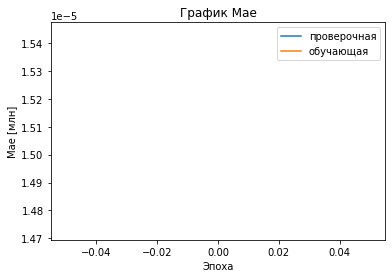

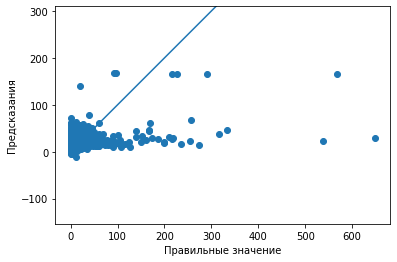

Number of unreachable objects collected by GC: 5464
Время обучения на эпохе - 4.8  время обучения суммарное - 4.8  времени остаётся до конца обучения - 43.0
Epoch 2/10
16/16 [==============================] - 4s 253ms/step - loss: 0.7591 - val_loss: 0.8166
Эпоха 1 модуль ошибки на проверочной 1.44436e-05
Эпоха 1 модуль ошибки на обучающей 1.22108e-05


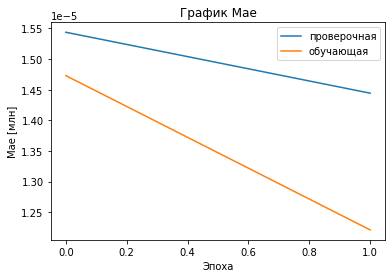

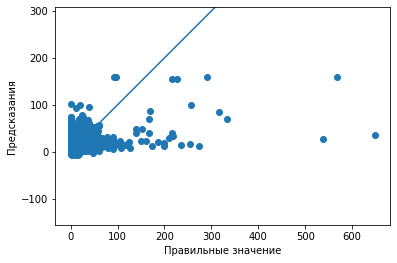

Number of unreachable objects collected by GC: 5291
Время обучения на эпохе - 4.4  время обучения суммарное - 9.2  времени остаётся до конца обучения - 36.7
Epoch 3/10
16/16 [==============================] - 4s 245ms/step - loss: 0.5283 - val_loss: 0.8215
Эпоха 2 модуль ошибки на проверочной 1.42367e-05
Эпоха 2 модуль ошибки на обучающей 1.03661e-05


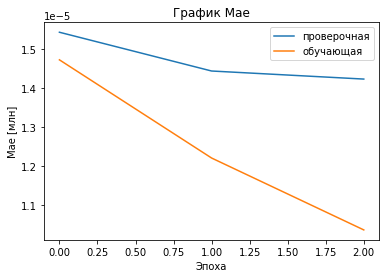

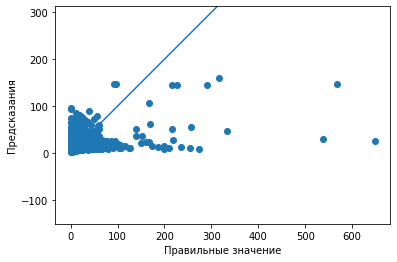

Number of unreachable objects collected by GC: 5449
Время обучения на эпохе - 4.3  время обучения суммарное - 13.5  времени остаётся до конца обучения - 31.4
Epoch 4/10
16/16 [==============================] - 4s 244ms/step - loss: 0.3322 - val_loss: 0.9414
Эпоха 3 модуль ошибки на проверочной 1.54316e-05
Эпоха 3 модуль ошибки на обучающей 9.8778e-06


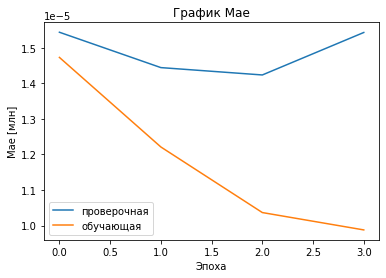

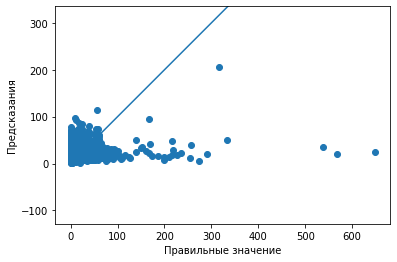

Number of unreachable objects collected by GC: 5391
Время обучения на эпохе - 4.4  время обучения суммарное - 17.8  времени остаётся до конца обучения - 26.8
Epoch 5/10
16/16 [==============================] - 4s 243ms/step - loss: 0.2990 - val_loss: 0.8188
Эпоха 4 модуль ошибки на проверочной 1.32246e-05
Эпоха 4 модуль ошибки на обучающей 7.502e-06


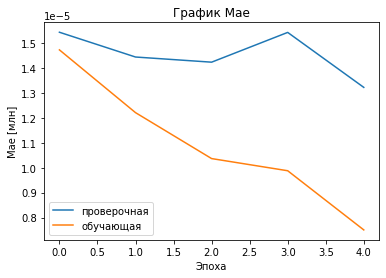

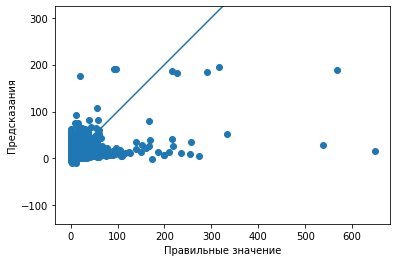

Number of unreachable objects collected by GC: 5623
Время обучения на эпохе - 4.4  время обучения суммарное - 22.3  времени остаётся до конца обучения - 22.3
Epoch 6/10
16/16 [==============================] - 4s 249ms/step - loss: 0.2284 - val_loss: 0.8574
Эпоха 5 модуль ошибки на проверочной 1.41297e-05
Эпоха 5 модуль ошибки на обучающей 6.6997e-06


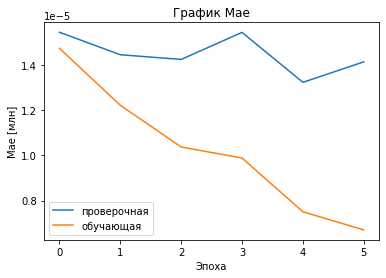

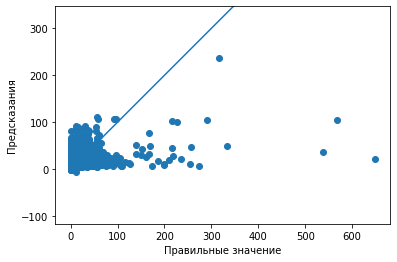

Number of unreachable objects collected by GC: 5017
Время обучения на эпохе - 4.1  время обучения суммарное - 26.4  времени остаётся до конца обучения - 17.6
Epoch 7/10
16/16 [==============================] - 4s 241ms/step - loss: 0.1367 - val_loss: 0.8390
Эпоха 6 модуль ошибки на проверочной 1.37729e-05
Эпоха 6 модуль ошибки на обучающей 5.8055e-06


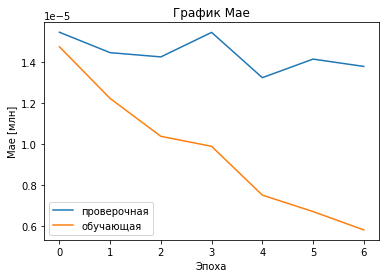

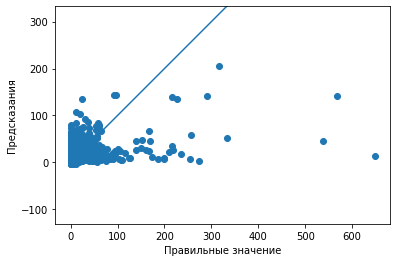

Number of unreachable objects collected by GC: 5133
Время обучения на эпохе - 4.1  время обучения суммарное - 30.5  времени остаётся до конца обучения - 13.1
Epoch 8/10
16/16 [==============================] - 4s 255ms/step - loss: 0.1260 - val_loss: 0.8258
Эпоха 7 модуль ошибки на проверочной 1.31469e-05
Эпоха 7 модуль ошибки на обучающей 5.392e-06


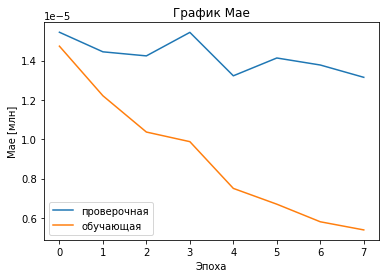

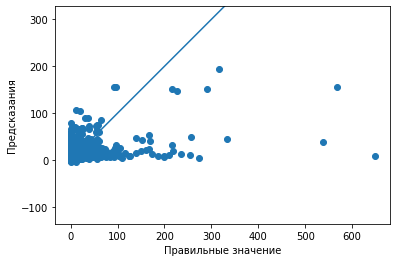

Number of unreachable objects collected by GC: 5391
Время обучения на эпохе - 4.3  время обучения суммарное - 34.7  времени остаётся до конца обучения - 8.7
Epoch 9/10
16/16 [==============================] - 4s 256ms/step - loss: 0.1093 - val_loss: 0.8526
Эпоха 8 модуль ошибки на проверочной 1.44217e-05
Эпоха 8 модуль ошибки на обучающей 5.1423e-06


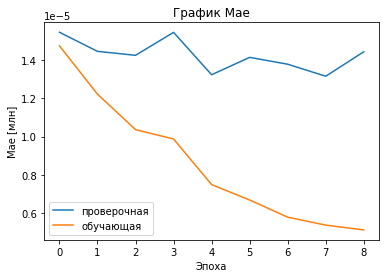

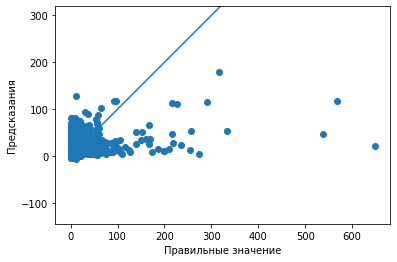

Number of unreachable objects collected by GC: 5399
Время обучения на эпохе - 3.9  время обучения суммарное - 38.7  времени остаётся до конца обучения - 4.3
Epoch 10/10
16/16 [==============================] - 4s 253ms/step - loss: 0.0814 - val_loss: 0.8369
Эпоха 9 модуль ошибки на проверочной 1.328e-05
Эпоха 9 модуль ошибки на обучающей 4.8739e-06


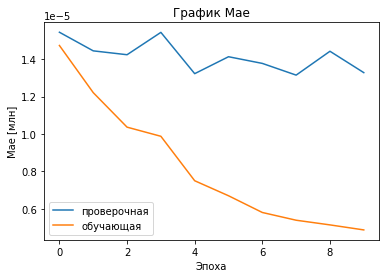

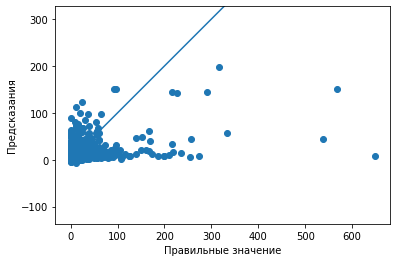

Number of unreachable objects collected by GC: 5217
Время обучения на эпохе - 4.3  время обучения суммарное - 43.0  времени остаётся до конца обучения - 0.0


In [ ]:
input1 = Input((xTrainScaled.shape[1]))
input2 = Input((xTrain01.shape[1]))

x1 = Dense(50, activation="relu")(input1)
x3 = Dropout(0.2)(x1)

x2 = Dense(1000, activation="relu")(input2)
x4 = Dropout(0.25)(x2)

x = concatenate([x3, x4])

x = Dense(200, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrain01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=10, 
                    validation_data=([xTrainScaled[valMask], xTrain01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=1,
                    callbacks=[pltMae],batch_size = 500)



## Examination

In [ ]:
model5 = load_model('/content/sample_data/m_best.h5')

In [ ]:
pred = model5.predict([xTrainScaled[valMask], xTrain01[valMask]])              #Полуаем выход сети на проверочно выборке
predUnscaled = yScaler.inverse_transform(pred).flatten()                      #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()   #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled                                         #Считаем разность предсказания и правильных цен
absDelta = abs(delta)                                                         #Берём модуль отклонения
print( "модуль ошибки на проверочной", round(sum(absDelta) / (1e+6 * len(absDelta)),10)) #Выводим усреднённую ошибку в миллионах рублей

модуль ошибки на проверочной 1.328e-05
